# Create Pytorch Geometric Data Objects

In [1]:
import pandas as pd
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import geopandas as gpd
from utils import createPytorchData

## Cargar datos de santiago y mapa de OSM

In [10]:
nodos_santiago = pd.read_csv('Data/dataset_santiago_ismt.csv')
nodos_santiago

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,comuna,node_id,division,prom_ismt,hogares,hog_40pct,pct_hog40p,AVE_GSE,uf2018
0,"-33.323944,-70.51263428391168",-0.306948,1.565049,0.572029,-1.137733,-0.120456,-0.561887,-33.323944,-70.512634,Lo Barnechea,1396118148,Lo Barnechea,0.915742,1087.0,10,0.009200,ABC1,80.723424
1,"-33.323944,-70.5127291",-0.421388,0.309495,0.368965,-0.098733,-0.103042,-0.162294,-33.323944,-70.512729,Lo Barnechea,1396118148,Lo Barnechea,0.915742,1087.0,10,0.009200,ABC1,80.723424
2,"-33.323944,-70.51298714285714",0.116505,0.164284,-0.110312,0.063860,0.391172,0.226372,-33.323944,-70.512987,Lo Barnechea,1396115711,Lo Barnechea,0.915742,1087.0,10,0.009200,ABC1,80.723424
3,"-33.323944,-70.51343609999999",-0.159113,-0.500987,-0.213503,0.635165,0.300856,0.453708,-33.323944,-70.513436,Lo Barnechea,9644543305,Lo Barnechea,0.915742,1087.0,10,0.009200,ABC1,80.723424
4,"-33.323944,-70.51379769565217",-1.226162,1.176751,1.462015,-0.842954,-0.946355,-0.936168,-33.323944,-70.513798,Lo Barnechea,1735562917,Lo Barnechea,0.915742,1087.0,10,0.009200,ABC1,80.723424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114184,"-33.67434854258675,-70.66824507886436",1.391164,-0.480694,-1.135939,0.324142,0.884354,0.961162,-33.674349,-70.668245,Buin,8961495191,Buin,0.731159,643.0,473,0.735614,D,18.538494
114185,"-33.6754716340694,-70.66824507886436",0.051756,-0.266517,-0.026096,0.383208,0.358507,0.183468,-33.675472,-70.668245,Buin,8904499951,Buin,0.731159,643.0,473,0.735614,D,18.538494
114186,"-33.67659472555205,-70.66824507886436",-0.041601,-0.957453,-0.226881,0.906073,0.253932,0.104719,-33.676595,-70.668245,Buin,314190696,Buin,0.731159,643.0,473,0.735614,D,18.538494
114187,"-33.6777178170347,-70.6694800851735",1.657702,0.324817,-1.200881,-0.120452,1.263557,1.156163,-33.677718,-70.669480,Buin,1320611525,Buin,0.731159,643.0,473,0.735614,D,18.538494


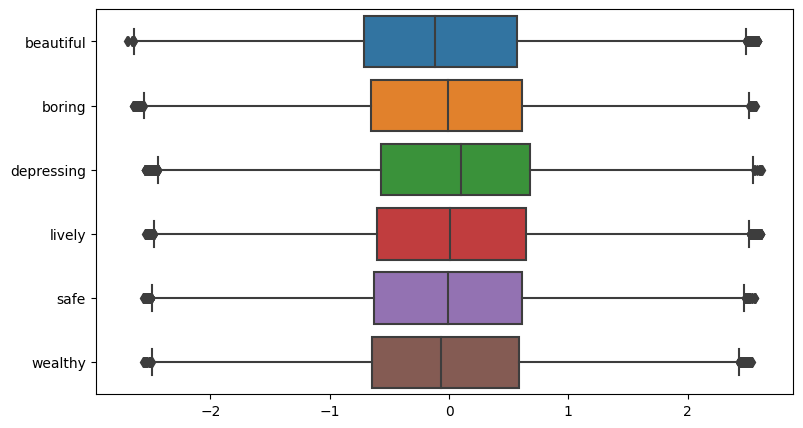

111082

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula los cuartiles
Q1 = nodos_santiago.iloc[:, [1,2,3,4,5,6]].quantile(0.25)
Q3 = nodos_santiago.iloc[:, [1,2,3,4,5,6]].quantile(0.75)
IQR = Q3 - Q1

# Define el rango intercuartílico para identificar los outliers
filtro_outliers = (nodos_santiago.iloc[:, [1,2,3,4,5,6]] < (Q1 - 1.5 * IQR)) | (nodos_santiago.iloc[:, [1,2,3,4,5,6]] > (Q3 + 1.5 * IQR))

# Aplica el filtro y elimina los outliers
nodos_santiago = nodos_santiago[~filtro_outliers.any(axis=1)]

# Grafica el boxplot sin outliers
plt.figure(figsize=(9,5))
boxplot_sin_outliers = sns.boxplot(data=nodos_santiago.iloc[:, [1,2,3,4,5,6]], orient="h")
plt.show()
len(nodos_santiago)


### Cambiar nombre comuna a int

In [12]:
nodos_santiago['division_num'] = pd.Categorical(nodos_santiago['division']).codes
print(nodos_santiago[['division', 'division_num']].drop_duplicates()[:5])

          division  division_num
0     Lo Barnechea            17
3342      Vitacura            41
3856        Colina             4
3893     Quilicura            30
4817         Lampa            15


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27444\1093571659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodos_santiago['division_num'] = pd.Categorical(nodos_santiago['division']).codes


In [13]:
num2div = {}
div2num = {}
for _, row in nodos_santiago[['division', 'division_num']].drop_duplicates().iterrows():
    num2div[row.division_num] = row.division
    div2num[row.division] = row.division_num

In [5]:
import pickle
with open('Data/Comunas/division2numbers.pkl', 'wb') as fp:
    pickle.dump(div2num, fp)
with open('Data/Comunas/numbers2division.pkl', 'wb') as fp:
    pickle.dump(num2div, fp)

### Cambiar categoría GSE a int

In [14]:
nodos_santiago['ave_gse_num'] = pd.Categorical(nodos_santiago['AVE_GSE']).codes
print(nodos_santiago[['AVE_GSE', 'ave_gse_num']].drop_duplicates()[:5])

      AVE_GSE  ave_gse_num
0        ABC1            0
911        C2            1
1848       C3            2
2250        D            3
13510       E            4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27444\1096910533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodos_santiago['ave_gse_num'] = pd.Categorical(nodos_santiago['AVE_GSE']).codes


In [15]:
num2gse = {}
gse2num = {}
for _, row in nodos_santiago[['AVE_GSE', 'ave_gse_num']].drop_duplicates().iterrows():
    num2gse[row.ave_gse_num] = row.AVE_GSE
    gse2num[row.AVE_GSE] = row.ave_gse_num

In [7]:
import pickle
with open('Data/ISMT/gse2numbers.pkl', 'wb') as fp:
    pickle.dump(gse2num, fp)
with open('Data/ISMT/numbers2gse.pkl', 'wb') as fp:
    pickle.dump(num2gse, fp)

In [16]:
G = ox.load_graphml("Maps/santiago_drive.graphml")
print(f'Number of nodes: {len(G.nodes())}')
print(f'Number of edges: {len(G.edges())}')
print(f'Number of strongly conncected components: {nx.number_strongly_connected_components(G)}')

Number of nodes: 355936
Number of edges: 673565
Number of strongly conncected components: 2450


In [17]:
components_length = [len(list(component)) for component in list(nx.strongly_connected_components(G))]
components_length.sort(reverse=True)
print(f"{round(components_length[0]/len(G.nodes()),5) * 100}% of nodes in one component")

99.259% of nodes in one component


## Add values to the complementary nodes of the OSM Graph

In [18]:
def get_nodes_attrs(G):
    attributes = {}
    for node, attrs in G.nodes.data():
        #print(f"Atributos de {node}: {', '.join(attrs.keys())}")
        for att in attrs.keys():
            if att not in attributes:
                attributes[att] = 0
            attributes[att] += 1
    return attributes

def get_edges_attrs(G):
    edges_atts = {}
    for u, v, attr in G.edges.data():
        for att in attr.keys():
            if att not in edges_atts:
                edges_atts[att] = 0
            edges_atts[att] += 1
    return edges_atts

In [19]:
# Se agregan los atributos como "boring", "lively" etc. a los nodos existentes que se encuentran en el grafo G
for _, row in nodos_santiago.iterrows():
    G.add_node(row.node_id, beautiful=row.beautiful, boring=row.boring,
               depressing=row.depressing, lively=row.lively,
               safe=row.safe, wealthy=row.wealthy, division=row.division_num, ismt=row.prom_ismt,
               houses=row.hogares, hog_40pct=row.hog_40pct, pct_hog40p=row.pct_hog40p, ave_gse= row.ave_gse_num, uf=row.uf2018)

In [20]:
get_nodes_attrs(G)

{'y': 355936,
 'x': 355936,
 'street_count': 355936,
 'highway': 35935,
 'beautiful': 82564,
 'boring': 82564,
 'depressing': 82564,
 'lively': 82564,
 'safe': 82564,
 'wealthy': 82564,
 'division': 82564,
 'ismt': 82564,
 'houses': 82564,
 'hog_40pct': 82564,
 'pct_hog40p': 82564,
 'ave_gse': 82564,
 'uf': 82564,
 'ref': 296}

In [21]:
get_edges_attrs(G)

{'osmid': 673565,
 'oneway': 673565,
 'lanes': 464509,
 'name': 598357,
 'highway': 673565,
 'reversed': 673565,
 'length': 673565,
 'speed_kph': 673565,
 'travel_time': 673565,
 'access': 6832,
 'maxspeed': 82877,
 'ref': 16508,
 'bridge': 2351,
 'junction': 3728,
 'width': 6784,
 'tunnel': 1847}

In [22]:
highway_dict = {}
highway_map = {}
i = 0
for u, v, attr in G.edges.data():
    h = attr['highway']
    if h not in highway_map:
        highway_map[h] = i
        i += 1
    if h not in highway_dict:
        highway_dict[h] = 0
    highway_dict[h] += 1

print(highway_dict)
print(highway_map)

{'primary': 32583, 'secondary': 44441, 'primary_link': 5217, 'tertiary': 76611, 'unclassified': 15926, 'residential': 296657, 'motorway_link': 9372, 'motorway': 9410, 'living_street': 179963, 'secondary_link': 2339, 'tertiary_link': 1032, 'road': 4, 'unclassified_link': 10}
{'primary': 0, 'secondary': 1, 'primary_link': 2, 'tertiary': 3, 'unclassified': 4, 'residential': 5, 'motorway_link': 6, 'motorway': 7, 'living_street': 8, 'secondary_link': 9, 'tertiary_link': 10, 'road': 11, 'unclassified_link': 12}


In [23]:
for u, v, k, data in G.edges(keys=True, data=True):
    if 'highway' in data:
        data['highway'] = highway_map.get(data['highway'], -1)

In [24]:
new_highway_dict = {}
for u, v, attr in G.edges.data():
    h = attr['highway']
    if h not in new_highway_dict:
        new_highway_dict[h] = 0
    new_highway_dict[h] += 1

print(new_highway_dict)

{0: 32583, 1: 44441, 2: 5217, 3: 76611, 4: 15926, 5: 296657, 6: 9372, 7: 9410, 8: 179963, 9: 2339, 10: 1032, 11: 4, 12: 10}


In [49]:
import matplotlib.pyplot as plt

def plot_highways(names):
    # Filtra los nodos y arcos que corresponden a los tipos de carretera en la lista 'names'
    selected_nodes = [node for node, data in G.nodes(data=True) if 'highway' in data and data['highway'] in names]
    selected_edges = [(u, v, key) for u, v, key, data in G.edges(keys=True, data=True) if 'highway' in data and data['highway'] in names]

    # Crear un subgrafo que contenga solo los nodos y arcos seleccionados
    subgraph = G.edge_subgraph(selected_edges)

    # Dibujar el subgrafo
    ox.plot_graph(ox.project_graph(subgraph), node_size=0, edge_linewidth=1, show=True)
   

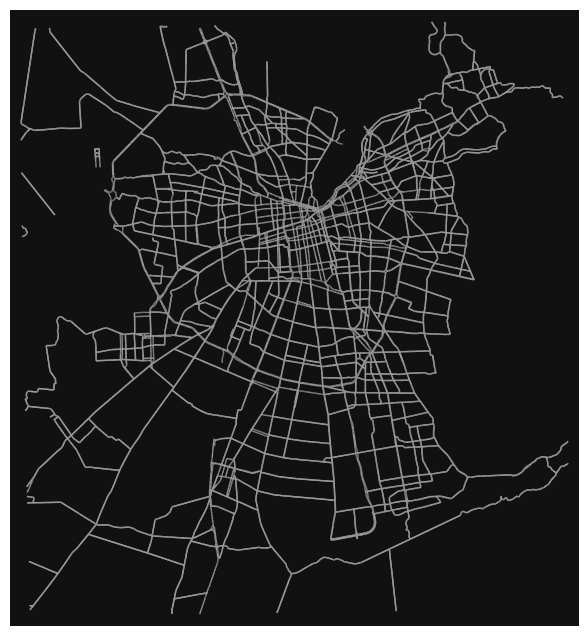

In [50]:
plot_highways(['primary', 'secondary'])

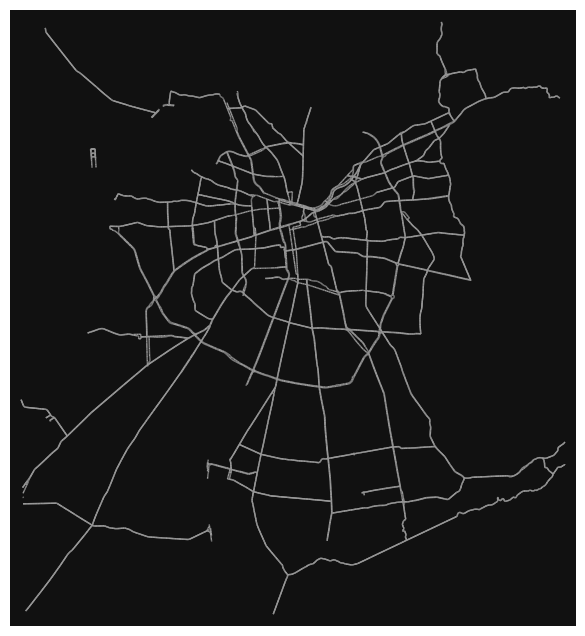

In [51]:
plot_highways(['primary'])

In [25]:
# Eliminar atributos extras de OSM
for node in G.nodes:
    if 'ref' in G.nodes[node]:
        G.nodes[node].pop('ref', None)
    if 'highway' in G.nodes[node]:
        G.nodes[node].pop('highway', None)
    if 'street_count' in G.nodes[node]:
        G.nodes[node].pop('street_count', None)

In [26]:
for u, v, attr in G.edges.data():
    for name in ['osmid', 'oneway', 'lanes', 'name', 'access', 'maxspeed', 'ref', 'bridge', 'junction', 'width', 'tunnel', 'osmid' 'oneway', 'reversed']:
        if name in attr:
            del attr[name]

In [27]:
get_nodes_attrs(G)

{'y': 355936,
 'x': 355936,
 'beautiful': 82564,
 'boring': 82564,
 'depressing': 82564,
 'lively': 82564,
 'safe': 82564,
 'wealthy': 82564,
 'division': 82564,
 'ismt': 82564,
 'houses': 82564,
 'hog_40pct': 82564,
 'pct_hog40p': 82564,
 'ave_gse': 82564,
 'uf': 82564}

In [28]:
get_edges_attrs(G)

{'highway': 673565,
 'length': 673565,
 'speed_kph': 673565,
 'travel_time': 673565}

In [29]:
df_comunas = gpd.read_file('Data/Comunas/COMUNAS_2020.shp')
df_ismt = gpd.read_file('Data/ISMT/ISMT.shp')
santiago_division = df_comunas[df_comunas.CUT_REG == '13']

def getDivision(point):
    for div in santiago_division.geometry:
        if point.within(div):
            return div
        
def getIsmtData(point):
    for com in df_ismt.geometry:
        if point.within(com):
            return com

def setDivisionNum(division: str):
    return div2num[division]

def setGSENum(gse):
    if gse in ['ABC1', 'C2', 'C3', 'D', 'E']:
        return gse2num[gse]
    return

def geoDataProcess(df_extra):
    # Obtener latitud y longitug
    lats = []
    lons = []
    for _, row in df_extra.iterrows():
        node = row.node_id
        lats.append(G.nodes[node]['y'])
        lons.append(G.nodes[node]['x'])
    df_extra['lat'] = lats
    df_extra['lon'] = lons

    coords_point = gpd.GeoDataFrame(df_extra, geometry=gpd.points_from_xy(df_extra.lon,df_extra.lat))
    coords_point['division'] = coords_point.geometry.apply(getDivision)
    tqdm.pandas()
    coords_point['geo_ismt'] = coords_point.geometry.progress_apply(getIsmtData)
    
    df_merge = coords_point.merge(santiago_division[['geometry', 'COMUNA']], left_on='division', right_on='geometry')
    df_merge = df_merge.drop(['geometry_x', 'geometry_y', 'division'], axis=1)
    df_merge = df_merge.rename({'COMUNA':'division'}, axis=1)
    df_merge['division_num'] = df_merge.division.apply(setDivisionNum)
    
    df_merge = df_merge.merge(df_ismt[['geometry', 'prom_ismt', 'hogares', 'hog_40pct', 'pct_hog40p', 'AVE_GSE', 'uf2018']], left_on='geo_ismt', right_on='geometry', how='left')
    df_extra = df_merge.drop(['geometry', 'geo_ismt'], axis=1)
    df_extra = df_extra.rename({'AVE_GSE':'ave_gse'}, axis=1)
    df_extra['ave_gse_num'] = df_extra.ave_gse.apply(setGSENum)

    return df_extra

In [30]:
ls_nodos_santiago = list(nodos_santiago.node_id.unique())
extra_nodes = list(set(G.nodes()) - set(ls_nodos_santiago))
len(extra_nodes) + 84252

357624

## Zero Map

In [31]:
# Setear valores de nodos extras en 0
ls_nodos_santiago = list(nodos_santiago.node_id.unique())
extra_nodes = list(set(G.nodes()) - set(ls_nodos_santiago))
print(f"Number of nodes: {len(extra_nodes)}")
beautiful_values = [0] * len(extra_nodes)
boring_values = [0] * len(extra_nodes)
depressing_values = [0] * len(extra_nodes)
lively_values = [0] * len(extra_nodes)
safe_values = [0] * len(extra_nodes)
wealthy_values = [0] * len(extra_nodes)

columns_name = ['node_id', 'beautiful', 'boring', 'depressing', 'lively', 'safe', 'wealthy']
df_extra = pd.DataFrame(list(zip(extra_nodes, beautiful_values, boring_values, depressing_values,
                                 lively_values, safe_values, wealthy_values)), columns=columns_name)


df_extra = geoDataProcess(df_extra)

Number of nodes: 273372


100%|██████████| 273372/273372 [1:26:09<00:00, 52.88it/s]  


In [32]:
df_extra

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,division,division_num,prom_ismt,hogares,hog_40pct,pct_hog40p,ave_gse,uf2018,ave_gse_num
0,9565110273,0,0,0,0,0,0,-33.600032,-70.591930,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
1,9565110274,0,0,0,0,0,0,-33.599970,-70.591940,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
2,2393618954,0,0,0,0,0,0,-33.580565,-70.605937,Puente Alto,29,0.778635,1336.0,683.0,0.511228,D,19.307412,3.0
3,9565110275,0,0,0,0,0,0,-33.600001,-70.591939,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
4,9538837257,0,0,0,0,0,0,-33.621177,-70.586392,Puente Alto,29,0.749758,1133.0,741.0,0.654016,D,13.774557,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273367,602912427,0,0,0,0,0,0,-33.327393,-70.624826,Colina,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273368,602912428,0,0,0,0,0,0,-33.327083,-70.624610,Colina,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273369,602914409,0,0,0,0,0,0,-33.330418,-70.627947,Colina,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273370,602914410,0,0,0,0,0,0,-33.329770,-70.627731,Colina,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_extra['ave_gse_num'] = df_extra.ave_gse_num.fillna(-1)
df_extra = df_extra.fillna(0)


In [34]:
df_extra

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,division,division_num,prom_ismt,hogares,hog_40pct,pct_hog40p,ave_gse,uf2018,ave_gse_num
0,9565110273,0,0,0,0,0,0,-33.600032,-70.591930,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
1,9565110274,0,0,0,0,0,0,-33.599970,-70.591940,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
2,2393618954,0,0,0,0,0,0,-33.580565,-70.605937,Puente Alto,29,0.778635,1336.0,683.0,0.511228,D,19.307412,3.0
3,9565110275,0,0,0,0,0,0,-33.600001,-70.591939,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
4,9538837257,0,0,0,0,0,0,-33.621177,-70.586392,Puente Alto,29,0.749758,1133.0,741.0,0.654016,D,13.774557,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273367,602912427,0,0,0,0,0,0,-33.327393,-70.624826,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0
273368,602912428,0,0,0,0,0,0,-33.327083,-70.624610,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0
273369,602914409,0,0,0,0,0,0,-33.330418,-70.627947,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0
273370,602914410,0,0,0,0,0,0,-33.329770,-70.627731,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0


In [35]:
for _, row in tqdm(df_extra.iterrows()):
    G.add_node(row.node_id, beautiful=row.beautiful, boring=row.boring,
               depressing=row.depressing, lively=row.lively,
               safe=row.safe, wealthy=row.wealthy, division=row.division_num, ismt=row.prom_ismt,
               houses=row.hogares, hog_40pct=row.hog_40pct, pct_hog40p=row.pct_hog40p, ave_gse= row.ave_gse_num, uf=row.uf2018)

273372it [00:28, 9572.15it/s] 


In [36]:
nodes_gse = {}
nodes_without_label = []
for node, att in G.nodes(data=True):
    gse = att['ave_gse']
    if gse not in nodes_gse:
        nodes_gse[gse] = 0
    nodes_gse[gse] += 1
    if gse == -1.0:
        nodes_without_label.append(node)
nodes_gse

{1.0: 81479, 2.0: 75121, 3: 130227, 0.0: 49550, -1.0: 18563, 4.0: 996}

In [37]:
print(f'Nodes to remove: {len(nodes_without_label)}')
G.remove_nodes_from(nodes_without_label)

Nodes to remove: 18563


In [38]:
nodes_ls = list(G.nodes())
c=0
dic_nodes = {}
for node in nodes_ls:
    dic_nodes[node] = c
    c+=1

G = nx.relabel_nodes(G, dic_nodes)

In [39]:
get_nodes_attrs(G)

{'y': 337373,
 'x': 337373,
 'beautiful': 337373,
 'boring': 337373,
 'depressing': 337373,
 'lively': 337373,
 'safe': 337373,
 'wealthy': 337373,
 'division': 337373,
 'ismt': 337373,
 'houses': 337373,
 'hog_40pct': 337373,
 'pct_hog40p': 337373,
 'ave_gse': 337373,
 'uf': 337373}

In [40]:
#ox.save_graphml(G, "Maps/santiago_drive_03_2024.graphml")

In [4]:
G = ox.load_graphml("Maps/santiago_drive_zero.graphml")

In [41]:
get_nodes_attrs(G)

{'y': 337373,
 'x': 337373,
 'beautiful': 337373,
 'boring': 337373,
 'depressing': 337373,
 'lively': 337373,
 'safe': 337373,
 'wealthy': 337373,
 'division': 337373,
 'ismt': 337373,
 'houses': 337373,
 'hog_40pct': 337373,
 'pct_hog40p': 337373,
 'ave_gse': 337373,
 'uf': 337373}

In [41]:
%%time
#betweenness_centrality = nx.betweenness_centrality(G, k=5000, weight='length')

CPU times: total: 6h 48min 24s
Wall time: 7h 59min 42s


In [6]:
import pickle
# with open('Data/bc.pkl', 'wb') as fp:
#     pickle.dump(betweenness_centrality, fp)

with open('Data/bc.pkl', 'rb') as fp:
    betweenness_centrality = pickle.load(fp)

In [42]:
eigen_centrality = nx.eigenvector_centrality_numpy(G, weight='length', max_iter=100)
pg_rank= nx.pagerank(G, weight='length')

In [8]:
len(betweenness_centrality), len(eigen_centrality), len(pg_rank)

(337374, 337374, 337374)

In [43]:
for node in tqdm(list(G.nodes())):
    G.nodes[node]['bc'] = 0
    G.nodes[node]['eigen'] = eigen_centrality[node]
    G.nodes[node]['pg_rank'] = pg_rank[node]

  0%|          | 0/337373 [00:00<?, ?it/s]

100%|██████████| 337373/337373 [00:00<00:00, 833468.76it/s]


In [44]:
createPytorchData(G, file_name='santiago_full_graph_2024')

Number of nodes: 337373
Number of edges: 641689
Number of edge attributes: 641689
Size of x tensor: torch.Size([337373, 18])
Size of edge_index tensor: torch.Size([2, 641689])
Size of edge_attributes tensor: torch.Size([641689, 4])
Graph saved as PyTorch in Data/santiago_full_graph_2024.pt


In [3]:
#G = ox.load_graphml("Maps/santiago_drive_zero.graphml")

## Filter Divisions

In [46]:
import pickle
with open('Data/Comunas/division2numbers.pkl', 'rb') as fp:
    div2num = pickle.load(fp)

In [47]:
numbers_commune_filter = []
tests_commune_filter = []
divisions = ['Santiago', 'Providencia', 'Ñuñoa', 'San Joaquín', 'San Miguel', 'Pedro Aguirre Cerda', 'Estación Central', 'Quinta Normal', 'Independencia', 'Recoleta']
test_divisions = ['Vitacura', 'Las Condes', 'Lo Barnechea', 'La Reina', 'Peñalolén']

for elem in divisions:
    numbers_commune_filter.append(div2num[elem])

# for elem in divisions:
#     tests_commune_filter.append(div2num[elem])

print(numbers_commune_filter)
# print(tests_commune_filter)

[39, 27, 42, 35, 37, 23, 7, 31, 9, 32]


In [48]:
for k, v in div2num.items():
    if k not in divisions:
        tests_commune_filter.append(v)

print(tests_commune_filter)

[17, 41, 4, 30, 15, 8, 5, 33, 28, 16, 3, 19, 21, 14, 25, 20, 2, 18, 34, 6, 22, 11, 12, 29, 13, 10, 38, 1, 36, 24, 26, 40, 0]


In [49]:
nodes_to_remove = []
for node, attrs in G.nodes(data=True):
    if int(attrs['division']) not in tests_commune_filter:
        nodes_to_remove.append(node)

print(f"Nodes reduced from {len(list(G.nodes()))} to {len(list(G.nodes())) - len(nodes_to_remove)}")
G.remove_nodes_from(nodes_to_remove)
len(list(G.nodes()))

Nodes reduced from 337373 to 280607


280607

In [50]:
get_nodes_attrs(G)

{'y': 280607,
 'x': 280607,
 'beautiful': 280607,
 'boring': 280607,
 'depressing': 280607,
 'lively': 280607,
 'safe': 280607,
 'wealthy': 280607,
 'division': 280607,
 'ismt': 280607,
 'houses': 280607,
 'hog_40pct': 280607,
 'pct_hog40p': 280607,
 'ave_gse': 280607,
 'uf': 280607,
 'bc': 280607,
 'eigen': 280607,
 'pg_rank': 280607}

In [15]:
get_edges_attrs(G)

{'highway': 543903,
 'length': 543903,
 'speed_kph': 543903,
 'travel_time': 543903}

In [51]:
nodes_ls = list(G.nodes())
c=0
dic_nodes = {}
for node in nodes_ls:
    dic_nodes[node] = c
    c+=1

G = nx.relabel_nodes(G, dic_nodes)

In [52]:
ox.save_graphml(G, "Maps/santiago_downtown_2024.graphml")

In [20]:
G = ox.load_graphml("Maps/santiago_downtown.graphml")

In [21]:
%%time
betweenness_centrality = nx.betweenness_centrality(G, k=5000, weight='length')

CPU times: total: 24min
Wall time: 51min 34s


In [18]:
eigen_centrality = nx.eigenvector_centrality_numpy(G, weight='length', max_iter=100)
pg_rank= nx.pagerank(G, weight='length')

In [18]:
for node in tqdm(list(G.nodes())):
    G.nodes[node]['bc'] = betweenness_centrality[node]
    G.nodes[node]['eigen'] = eigen_centrality[node]
    G.nodes[node]['pg_rank'] = pg_rank[node]

100%|██████████| 280608/280608 [00:00<00:00, 838458.61it/s]


In [53]:
createPytorchData(G, file_name='santiago_downtown_2024')

Number of nodes: 280607
Number of edges: 543901
Number of edge attributes: 543901
Size of x tensor: torch.Size([280607, 18])
Size of edge_index tensor: torch.Size([2, 543901])
Size of edge_attributes tensor: torch.Size([543901, 4])
Graph saved as PyTorch in Data/santiago_downtown_2024.pt


## Mean Global

In [35]:
# Setear valores de nodos extras en media global
ls_nodos_santiago = list(nodos_santiago.node_id.unique())
extra_nodes = list(set(G.nodes()) - set(ls_nodos_santiago))

beautiful_values = [nodos_santiago['beautiful'].median()] * len(extra_nodes)
boring_values = [nodos_santiago['boring'].median()] * len(extra_nodes)
depressing_values = [nodos_santiago['depressing'].median()] * len(extra_nodes)
lively_values = [nodos_santiago['lively'].median()] * len(extra_nodes)
safe_values = [nodos_santiago['safe'].median()] * len(extra_nodes)
wealthy_values = [nodos_santiago['wealthy'].median()] * len(extra_nodes)

columns_name = ['node_id', 'beautiful', 'boring', 'depressing', 'lively', 'safe', 'wealthy']
df_extra = pd.DataFrame(list(zip(extra_nodes, beautiful_values, boring_values, depressing_values,
                                 lively_values, safe_values, wealthy_values)), columns=columns_name)


df_extra = geoDataProcess(df_extra)

In [37]:
for _, row in tqdm(df_extra.iterrows()):
    G.add_node(row.node_id, beautiful=row.beautiful, boring=row.boring,
               depressing=row.depressing, lively=row.lively,
               safe=row.safe, wealthy=row.wealthy, comuna=row.comuna_num)

268038it [00:18, 14178.12it/s]


In [38]:
ox.save_graphml(G, "Maps/santiago_drive_global_mean.graphml")

In [39]:
createPytorchData(G, file_name='santiago_global_mean')

Number of nodes: 355936
Number of edges: 673565
Number of edge attributes: 673565
Size of x tensor: torch.Size([355936, 9])
Size of edge_index tensor: torch.Size([2, 673565])
Size of edge_attributes tensor: torch.Size([673565, 2])
Graph saved as PyTorch in Data/santiago_global_mean.pt
